<a href="https://colab.research.google.com/github/anjalii-s/Myerson-Owen-Taiwan/blob/main/1_default_2_lakh_dataset_Coursera_Kaggle_loan_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✓ CSV loaded: (227973, 18)
       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  AWSBW843Q1   56   62996      117825          486              90   
1  OZKH1K1SKG   26  102924       86556          464             101   
2  TG22V9PWEG   48   71536      249742          444              77   
3  XHY1QSXPXG   57  145307      180646          510              25   
4  KNUOG8Q45R   35   72117      229909          435             104   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               2         23.04        12      0.19     Master's   
1               3          3.41        60      0.63          PhD   
2               1          9.39        60      0.75          PhD   
3               3         15.52        24      0.87  High School   
4               3          9.49        24      0.76          PhD   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0  Self-employed      Divorced          No           Yes    Busin

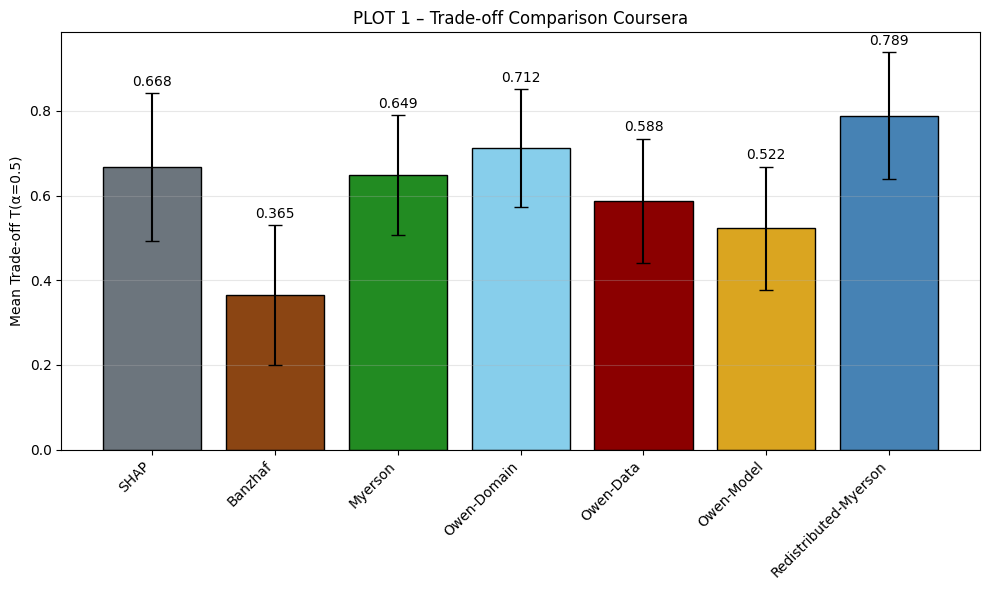

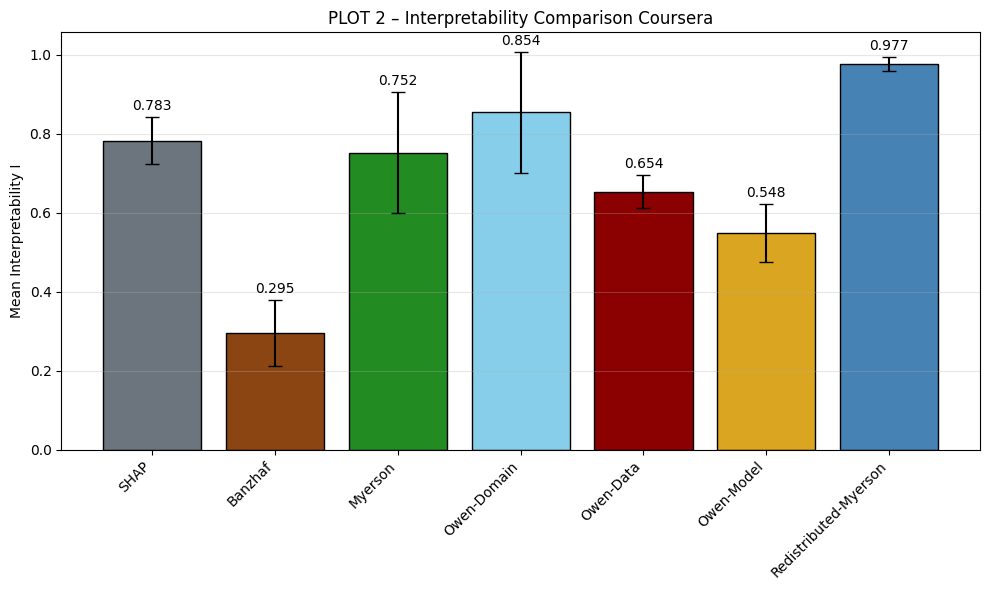

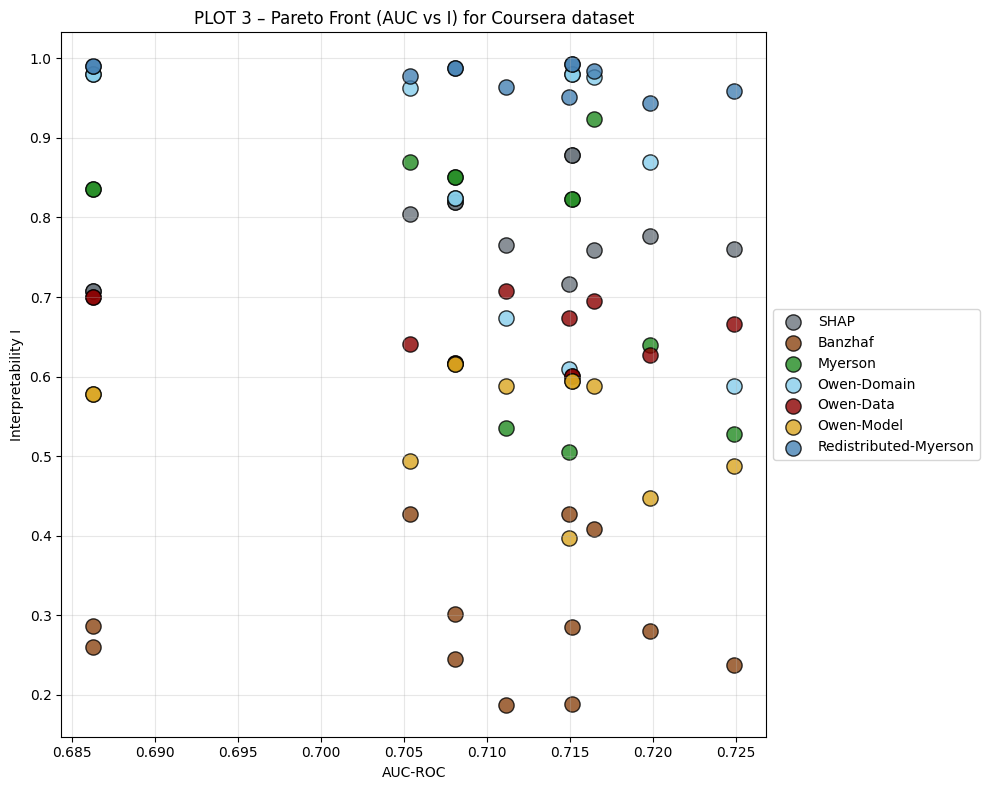

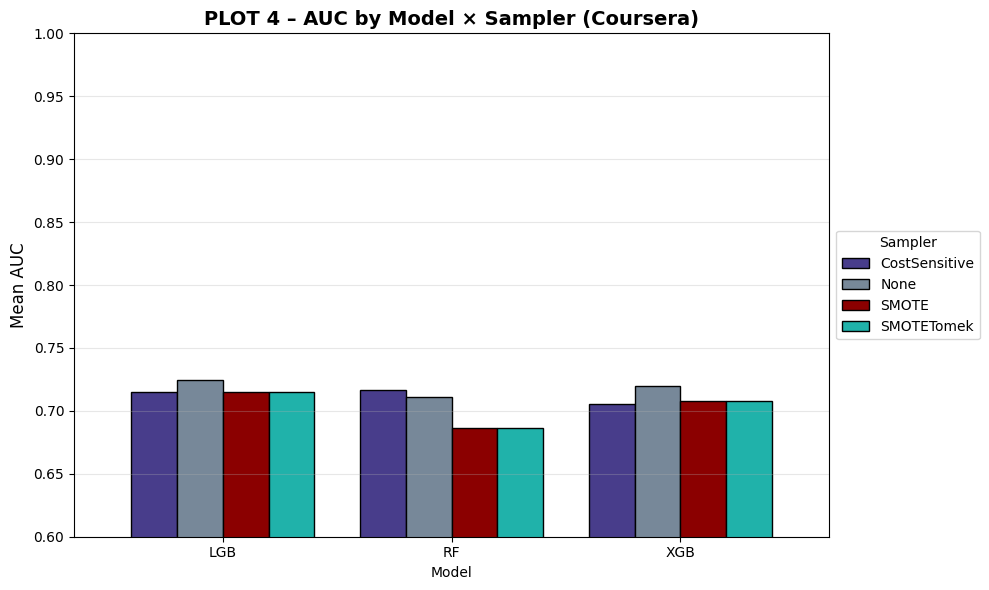

[LightGBM] [Info] Number of positive: 1595, number of negative: 157986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316
[LightGBM] [Info] Number of data points in the train set: 159581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009995 -> initscore=-4.595633
[LightGBM] [Info] Start training from score -4.595633


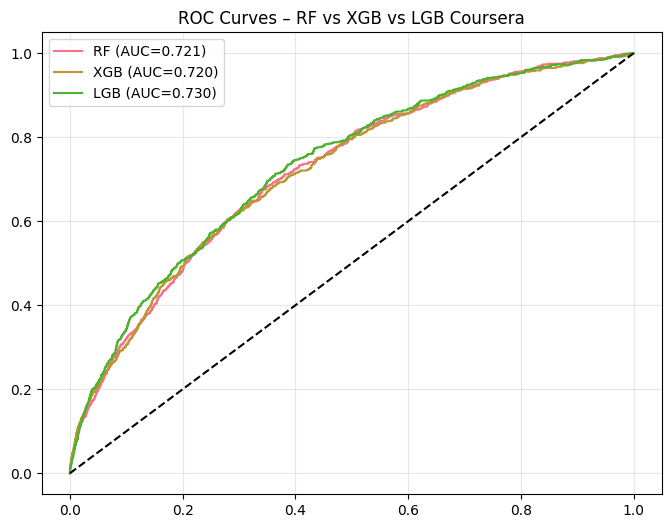

[LightGBM] [Info] Number of positive: 1595, number of negative: 157986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316
[LightGBM] [Info] Number of data points in the train set: 159581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009995 -> initscore=-4.595633
[LightGBM] [Info] Start training from score -4.595633


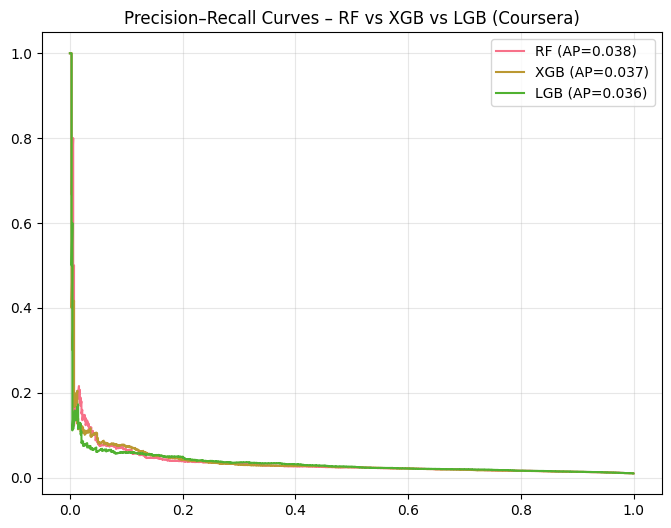

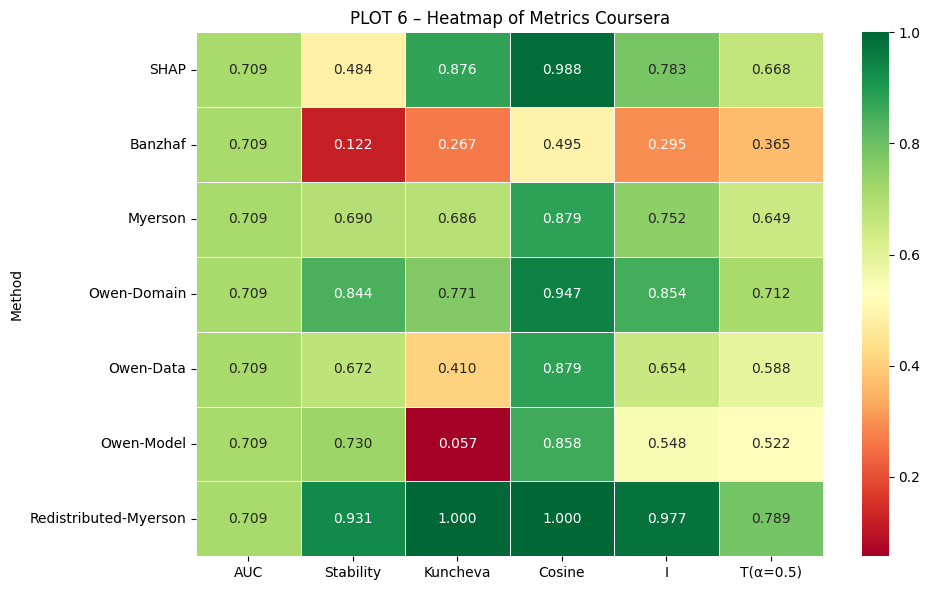

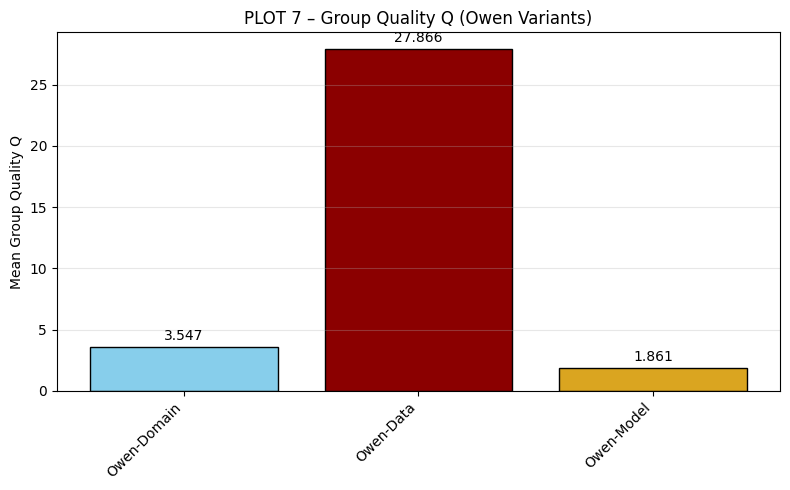

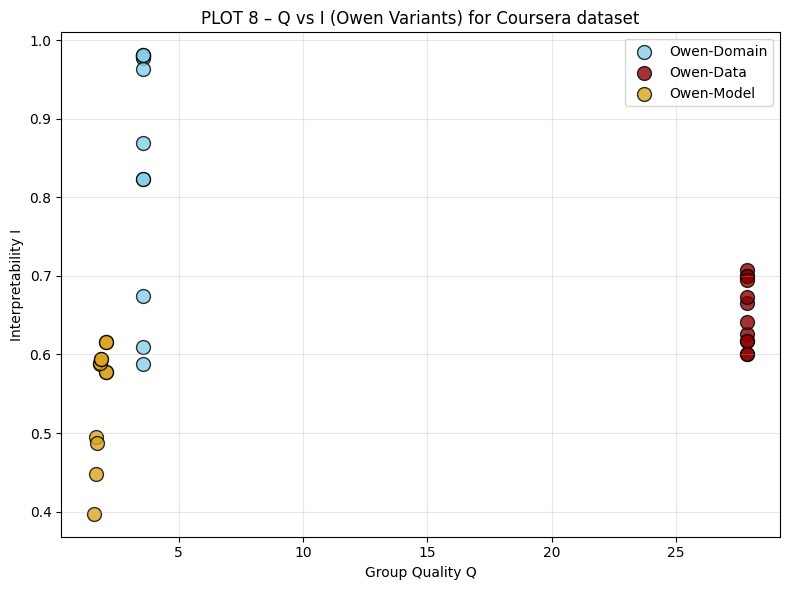

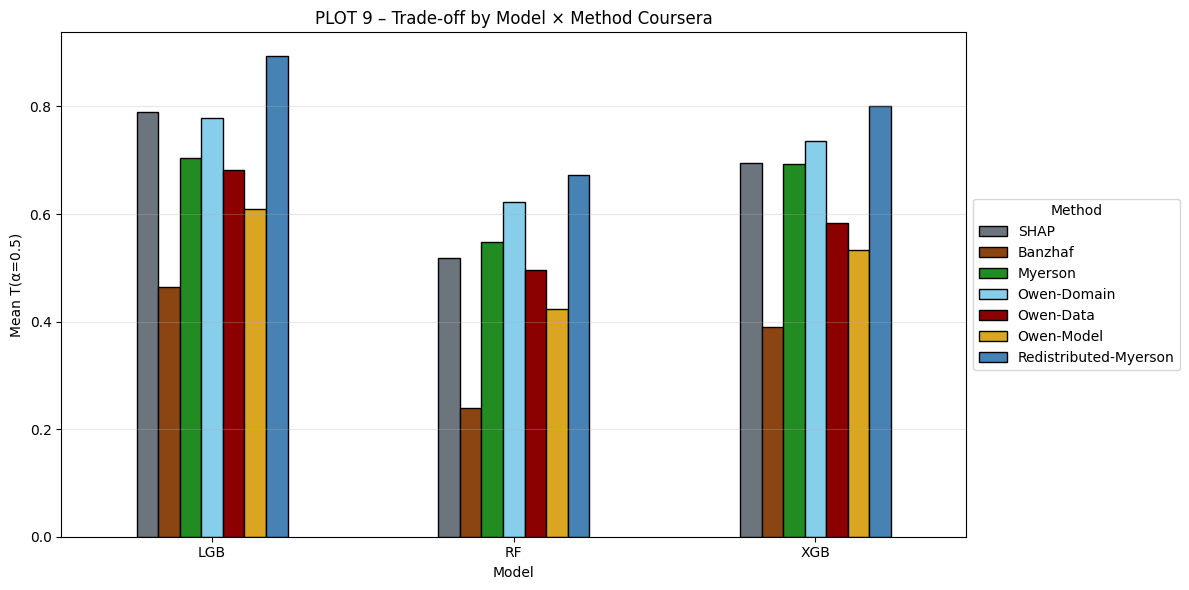

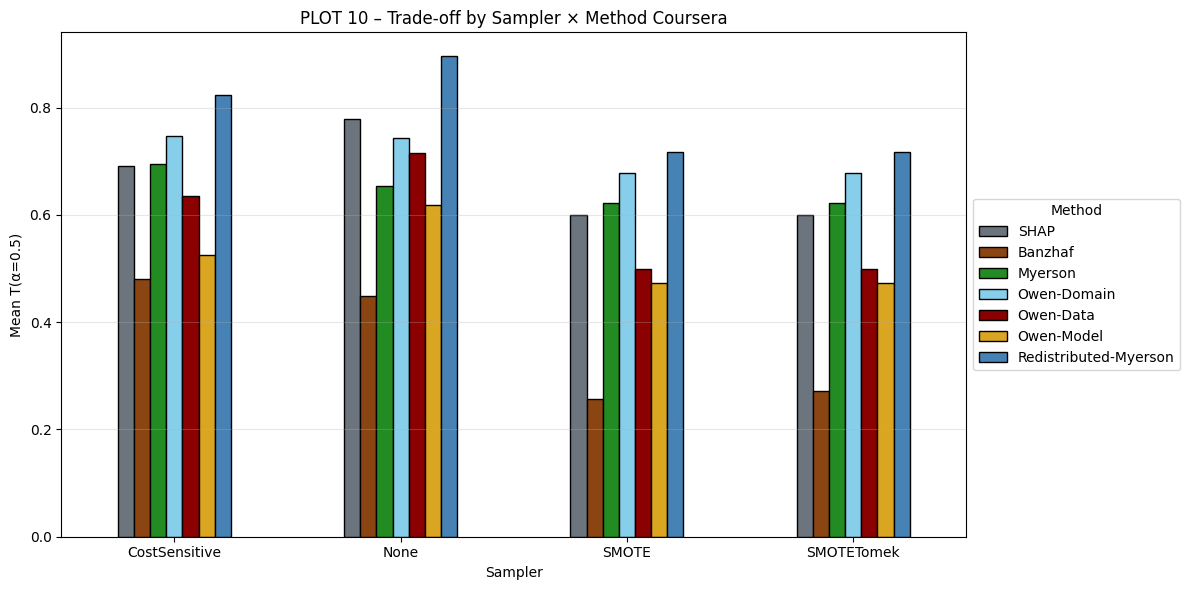

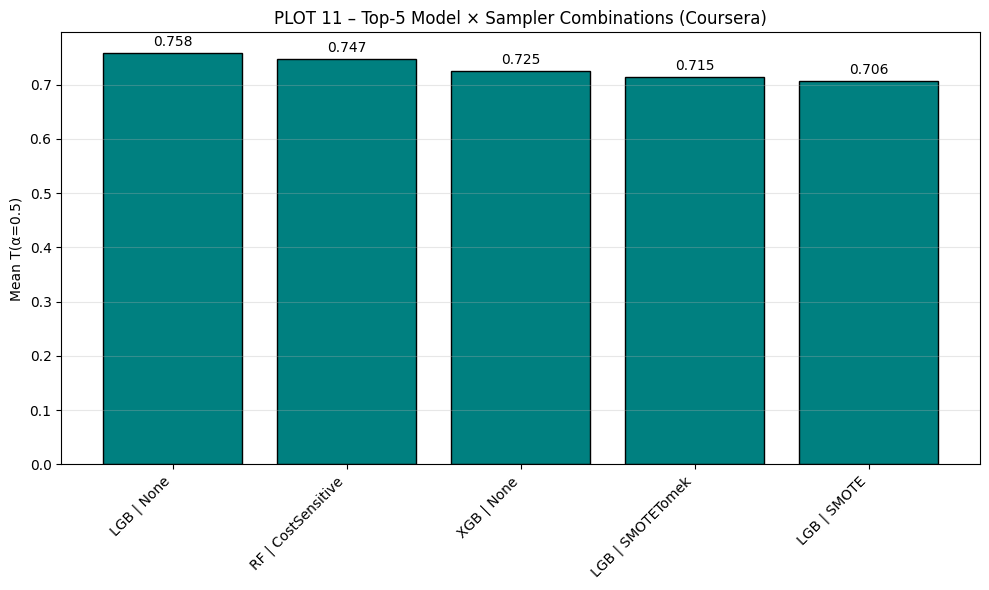

[LightGBM] [Info] Number of positive: 1595, number of negative: 157986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316
[LightGBM] [Info] Number of data points in the train set: 159581, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009995 -> initscore=-4.595633
[LightGBM] [Info] Start training from score -4.595633


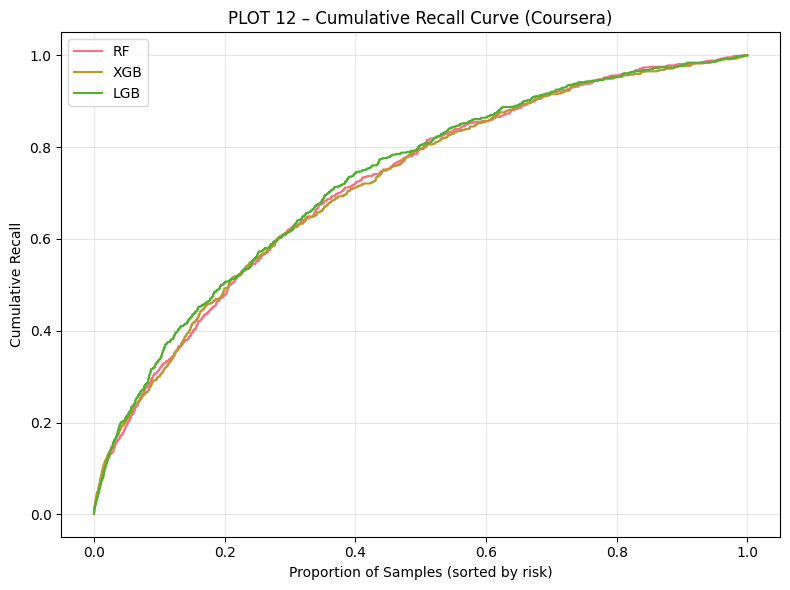

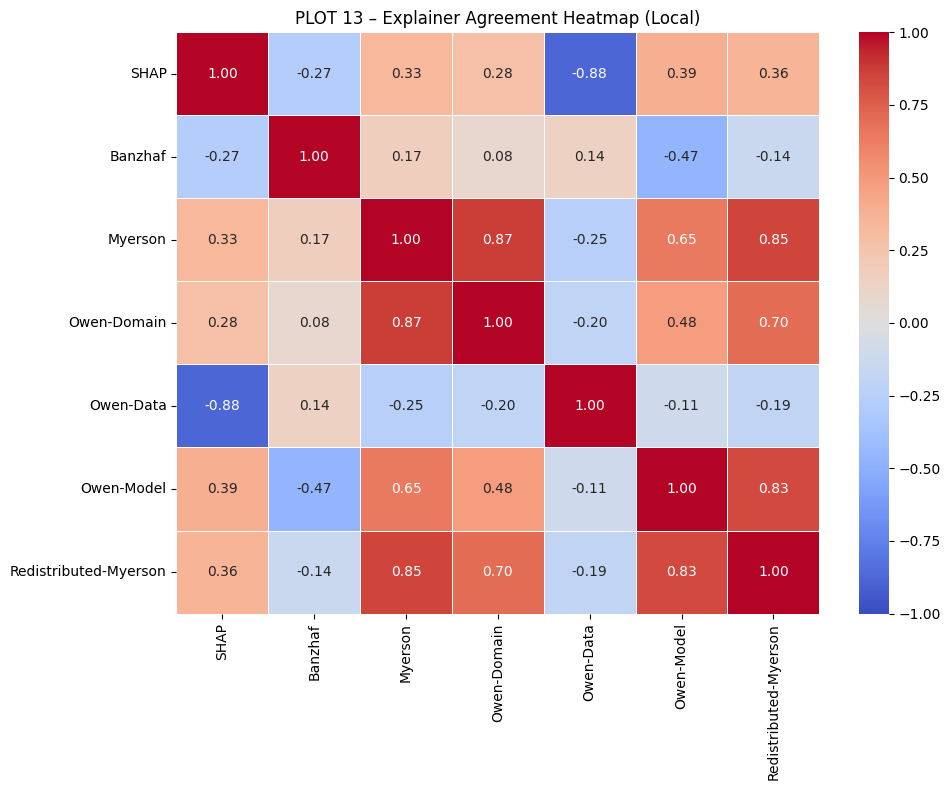

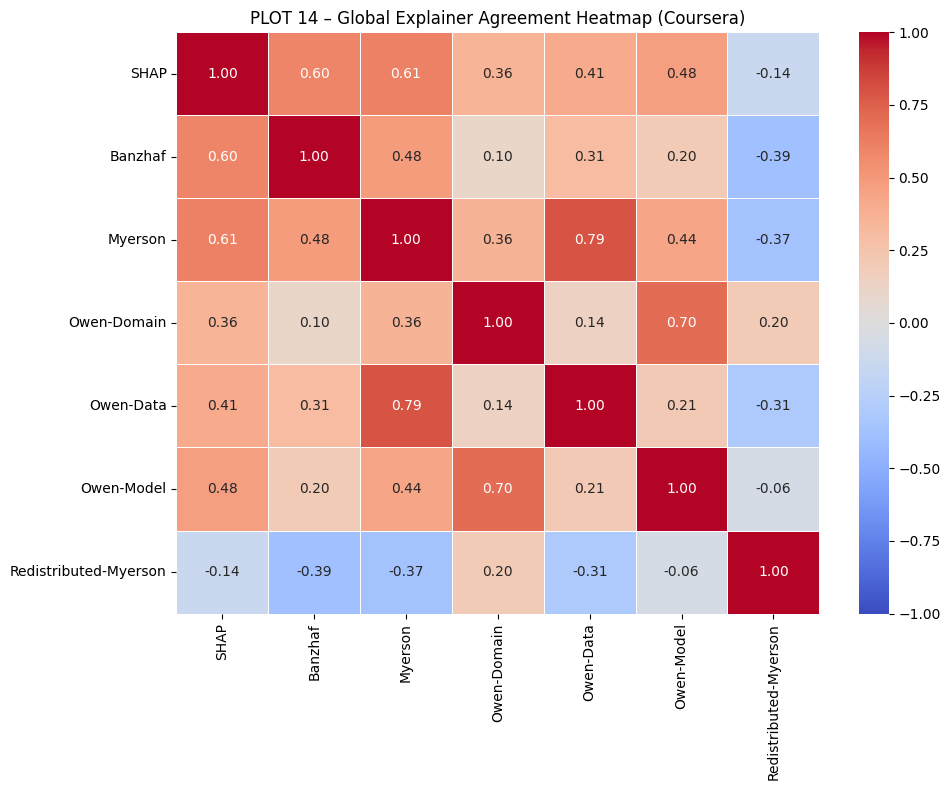


==================== STATISTICAL ANALYSIS ====================

Methods included: ['Banzhaf', 'Myerson', 'Owen-Data', 'Owen-Domain', 'Owen-Model', 'Redistributed-Myerson', 'SHAP'] 

=== Normality Tests (Shapiro or fallback) ===
Banzhaf               p=0.035685  ✓  → non-normal
Myerson               p=0.166303  ✗  → normal
Owen-Data             p=0.139411  ✗  → normal
Owen-Domain           p=0.180203  ✗  → normal
Owen-Model            p=0.025817  ✓  → non-normal
Redistributed-Myerson  p=0.030765  ✓  → non-normal
SHAP                  p=0.009667  ✓  → non-normal

=== Levene Test (Variance Homogeneity) ===
Levene p=0.999444  ✗  → variances equal

=== Friedman Test (Overall Differences) ===
Friedman p=0.000000  ✓  → significant differences between methods

=== Pairwise Wilcoxon Tests + Effect Sizes ===
Banzhaf         vs Myerson          p=0.000488  ✓  Cliff’s δ=-0.861 (large)
Banzhaf         vs Owen-Data        p=0.000488  ✓  Cliff’s δ=-0.736 (large)
Banzhaf         vs Owen-Domain      p

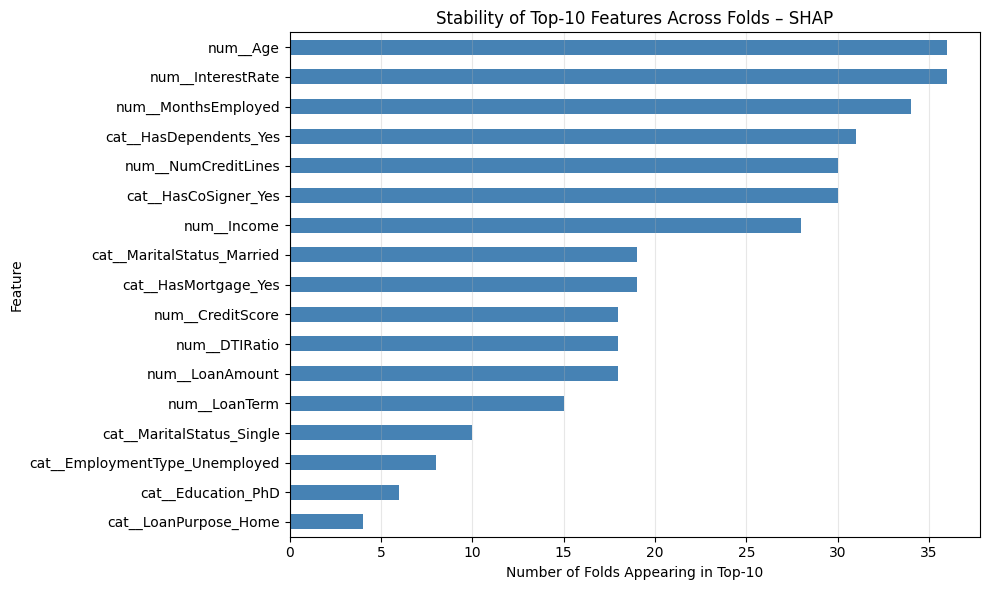

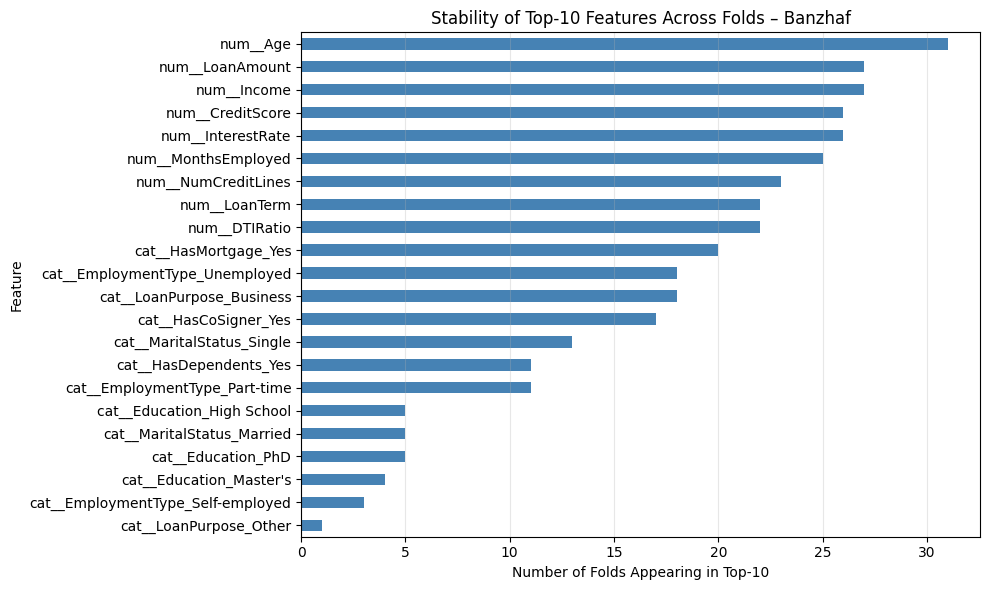

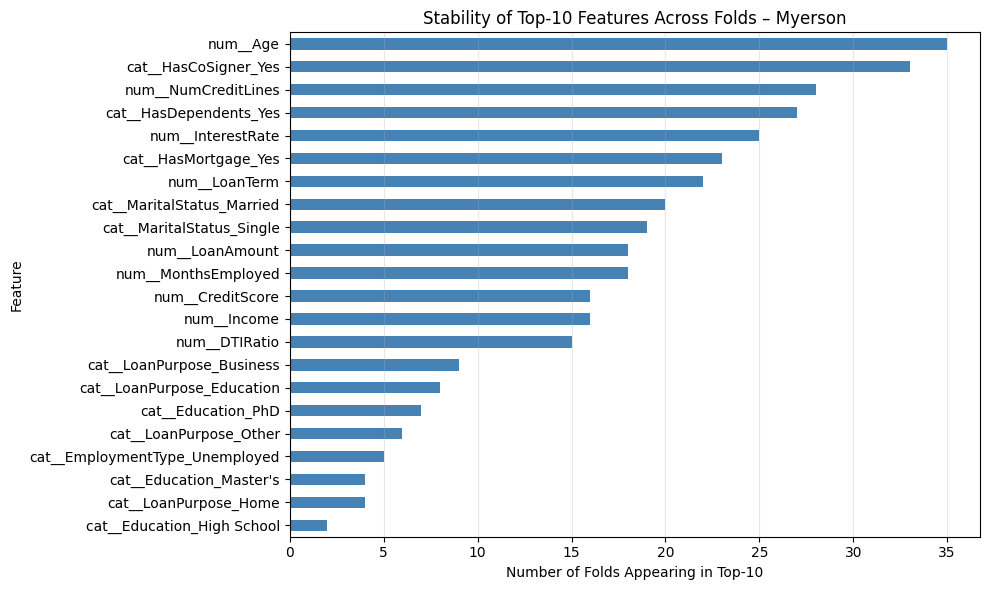

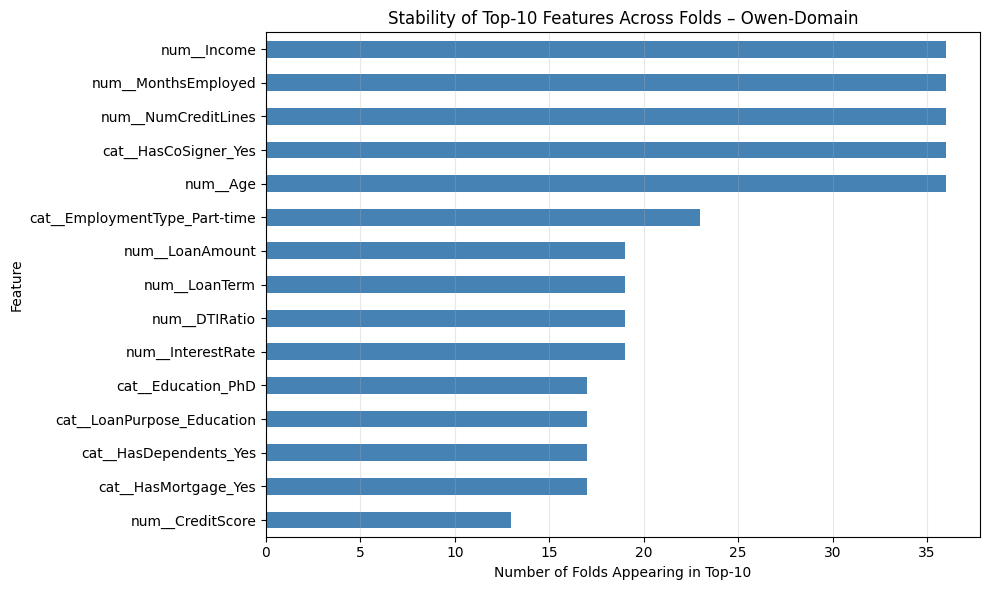

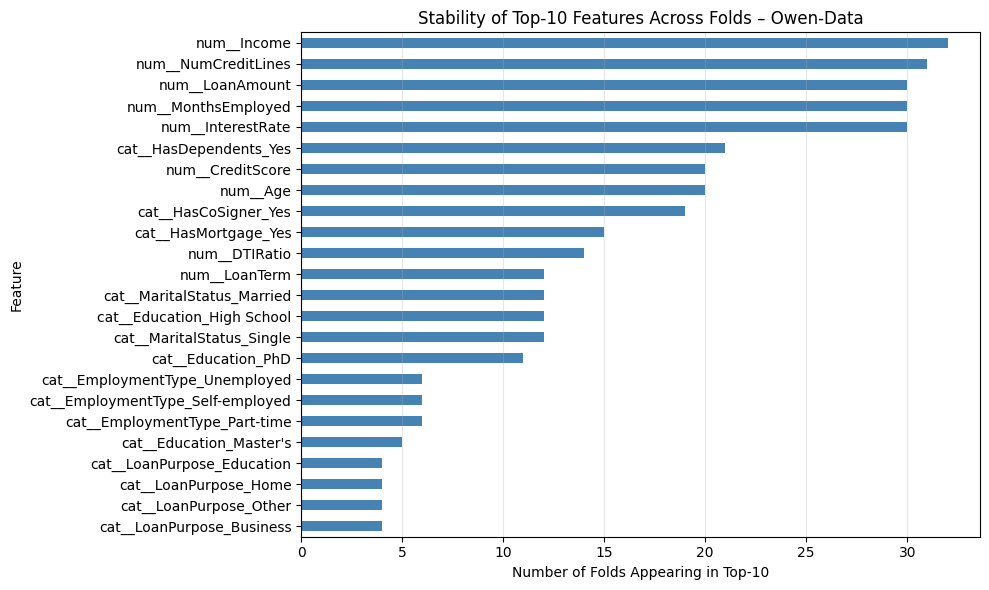

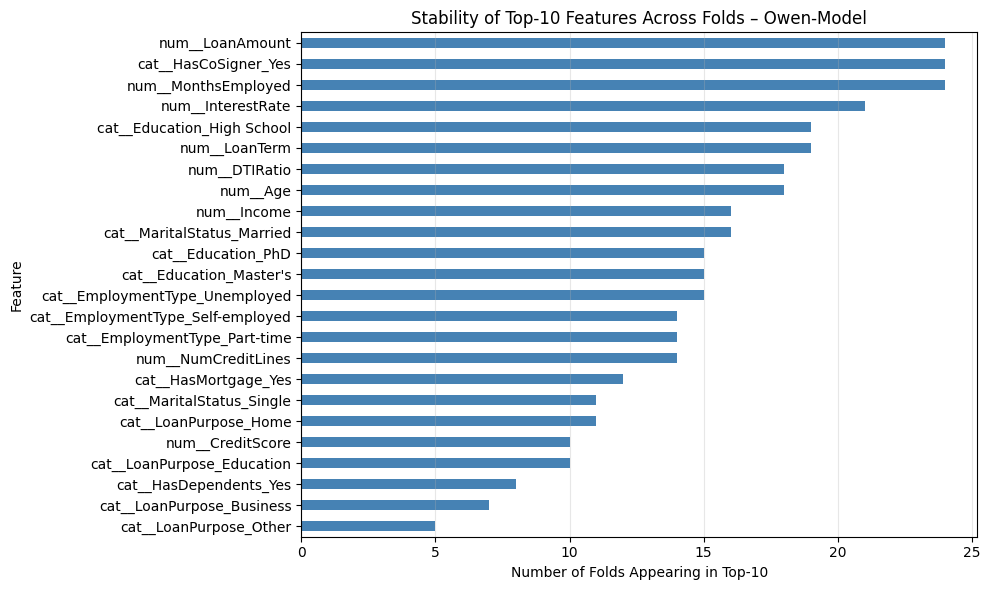

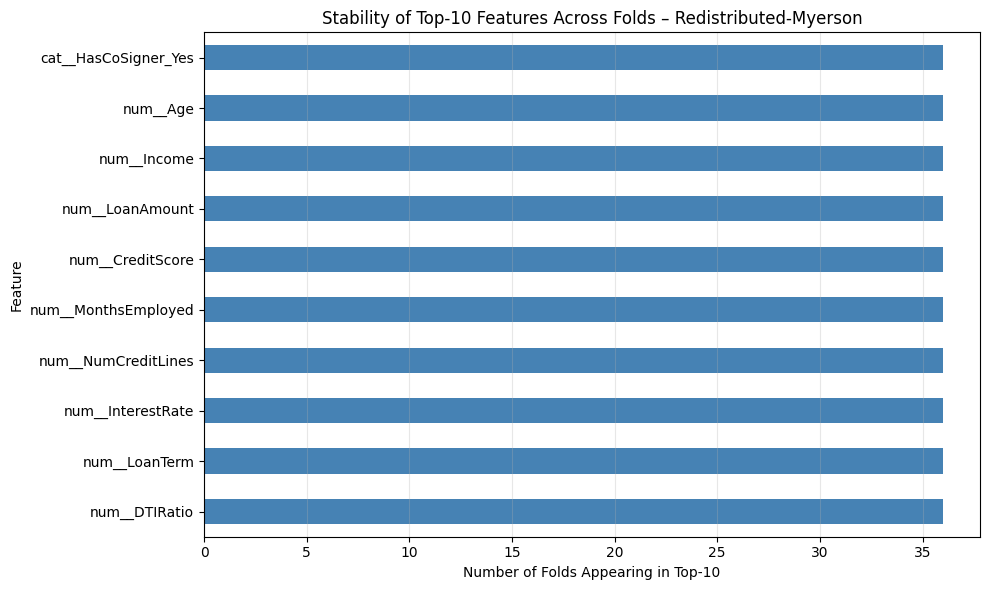

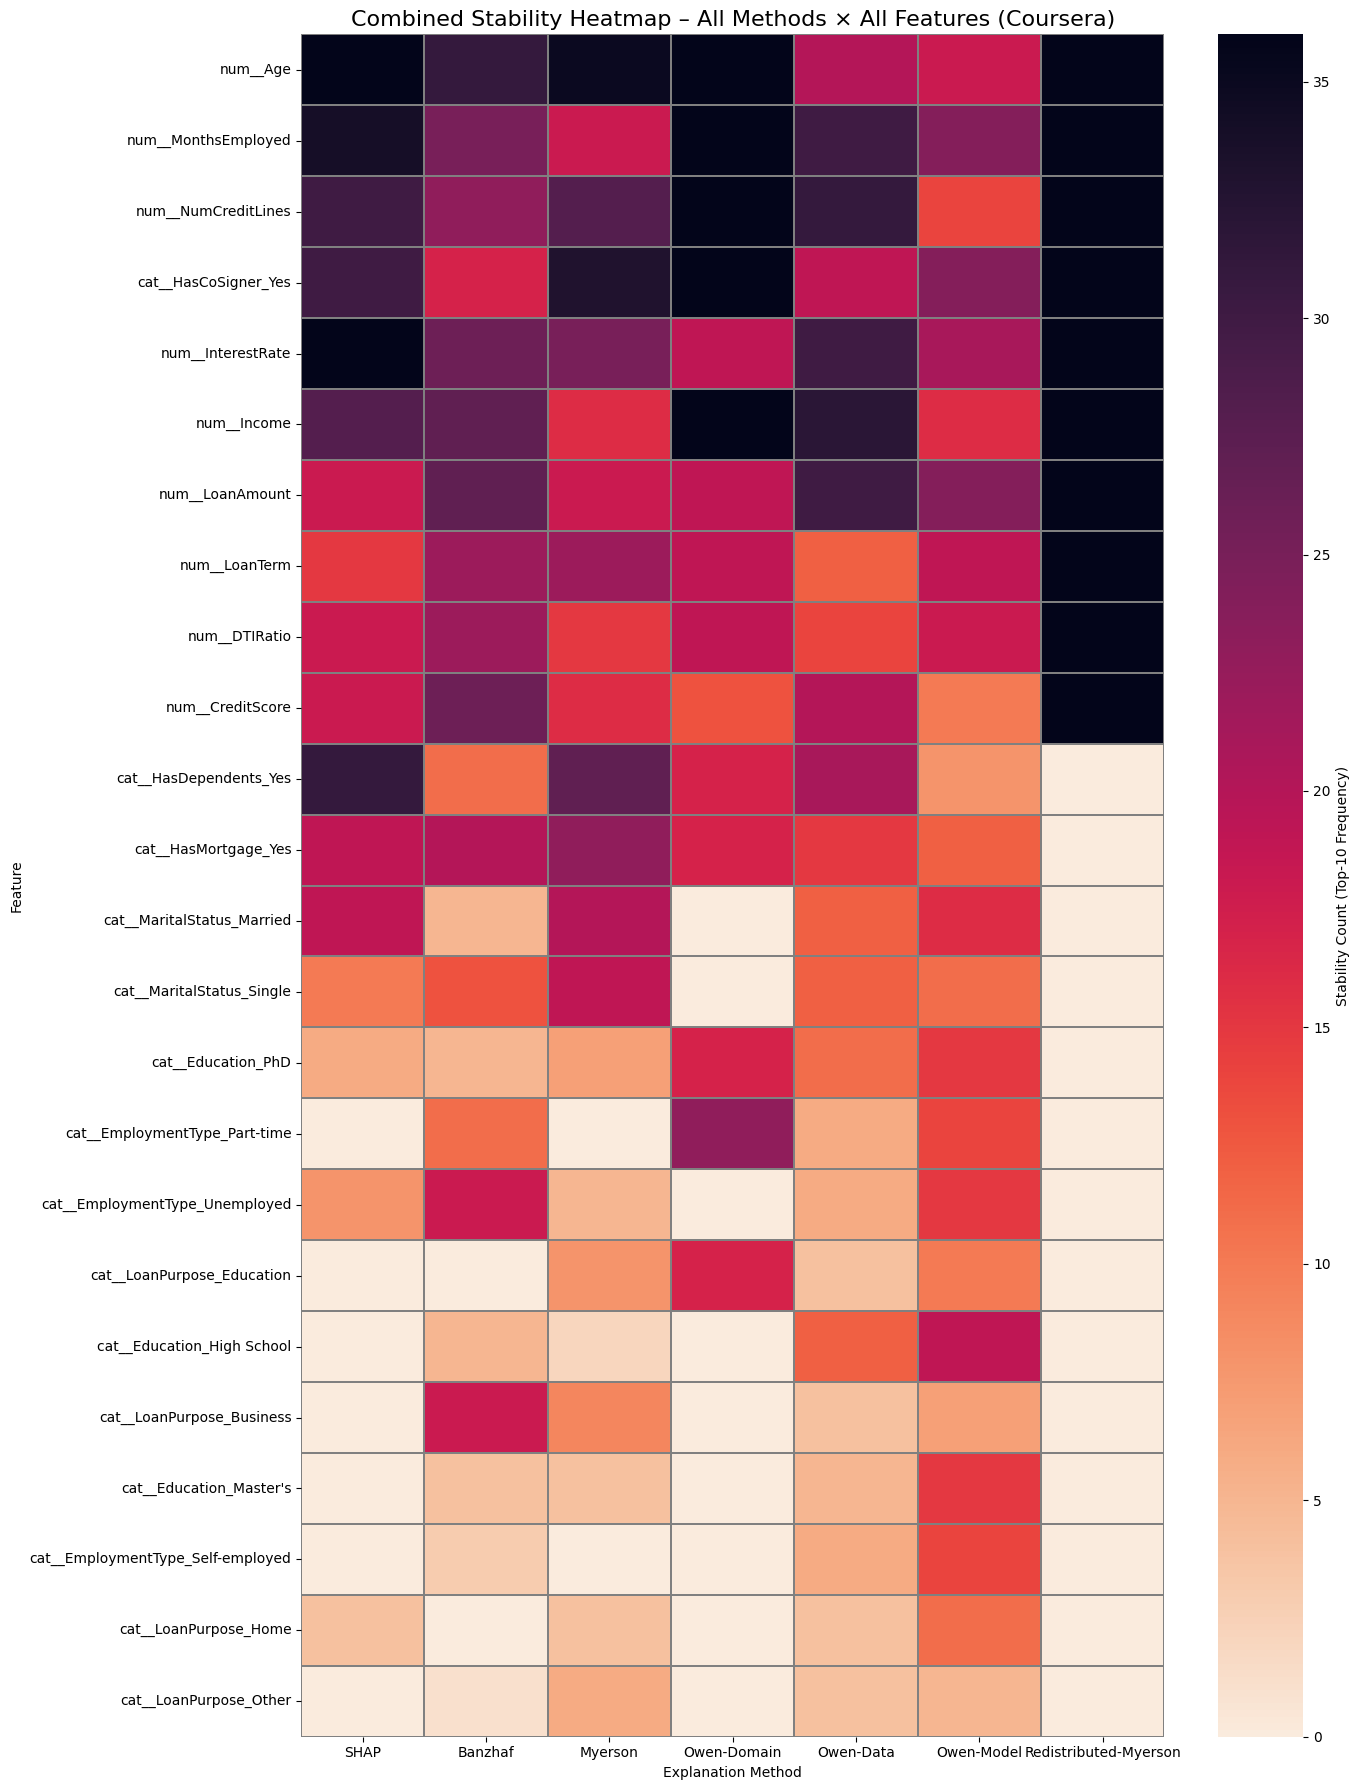

In [3]:
import warnings
warnings.filterwarnings('ignore')
!pip install --quiet xgboost lightgbm imbalanced-learn shap networkx seaborn
!pip install --quiet numba

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score


import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

import os

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD DATA (ADJUST PATH IF NEEDED)
# ============================================================



df = pd.read_csv('/content/Loan_Coursera_1%.csv')
print("✓ CSV loaded:", df.shape)
print(df.head())
print(df.info())

# ============================================================
# 2. PREPROCESSING
# ============================================================

# Drop ID
df = df.drop(columns=['LoanID'])

# Target
y = df['Default']
X = df.drop(columns=['Default'])

# Categorical features
categorical_features = [
    'Education',
    'EmploymentType',
    'MaritalStatus',
    'HasMortgage',
    'HasDependents',
    'LoanPurpose',
    'HasCoSigner'
]

# Convert to string
for col in categorical_features:
    X[col] = X[col].astype(str)

# Numeric features
numeric_features = [
    'Age',
    'Income',
    'LoanAmount',
    'CreditScore',
    'MonthsEmployed',
    'NumCreditLines',
    'InterestRate',
    'LoanTerm',
    'DTIRatio'
]

# OHE categories
cat_categories = [sorted(X[col].unique()) for col in categorical_features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False, categories=cat_categories), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
d = X_processed.shape[1]

print("Processed features:", d)

# ============================================================
# 3. MODELS (GPU ENABLED WHERE POSSIBLE)
# ============================================================

models = {
    'RF': RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ),
    'XGB': xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        tree_method='hist',      # GPU
        predictor='cpu_predictor',   # GPU
        random_state=42
    ),
    'LGB': lgb.LGBMClassifier(
        n_estimators=300,
        max_depth=-1,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        device='cpu'                 # GPU
    )
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

class_weight_dict = {
    int(cls): float(w)
    for cls, w in zip(np.unique(y), compute_class_weight('balanced', classes=np.unique(y), y=y))
}

# ============================================================
# 4. DOMAIN GROUPS
# ============================================================

def build_domain_groups_coursera(fnames):
    groups = {
        "LoanTerms": [],
        "BorrowerProfile": [],
        "CreditHistory": [],
        "LoanMetadata": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        # Loan Terms & Pricing
        if any(k in lname for k in [
            "loanamount", "interestrate", "loanterm", "dtiratio"
        ]):
            groups["LoanTerms"].append(i)

        # Borrower Profile
        elif any(k in lname for k in [
            "age", "income", "monthsemployed", "numcreditlines",
            "education", "employmenttype", "maritalstatus",
            "hasdependents", "hasmortgage", "hascosigner"
        ]):
            groups["BorrowerProfile"].append(i)

        # Credit History
        elif "creditscore" in lname:
            groups["CreditHistory"].append(i)

        # Loan Metadata
        elif "loanpurpose" in lname:
            groups["LoanMetadata"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

domain_groups = build_domain_groups_coursera(feature_names)
print("Domain groups:", {k: len(v) for k, v in domain_groups.items()})

# ============================================================
# 5. EXPLANATION METHODS
# ============================================================

def get_shap_reliable(pipe, X_test):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"  SHAP failed: {e}")
        n_features = X_proc.shape[1]
        return np.zeros((len(X_test), n_features))


def compute_banzhaf(pipe, X_test, n_samples=2, max_instances=2):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat


def compute_myerson(pipe, X_test, G, alpha=0.5):
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i)) if i in G.nodes() else []
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors if j < d_local])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(50, len(X_test)), 1)), shap_vals, shap_mean


def build_data_groups(X_proc, n_groups=5):
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr, nan=0.0)
        np.fill_diagonal(corr, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)


def build_model_groups(shap_vals, n_groups=5):
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0)
        np.fill_diagonal(corr, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)


def owen_from_phi(phi, groups):
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out


def compute_Q(groups, dep):
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except:
        return np.nan


def adaptive_owen_myerson(phi_my):
    d_local = len(phi_my)
    total = np.sum(np.abs(phi_my))
    if d_local == 0:
        return phi_my
    per = total / d_local
    out = np.zeros(d_local)
    for i in range(d_local):
        sign = np.sign(phi_my[i]) if phi_my[i] != 0 else 1
        out[i] = sign * per
    return out

print("✓ Explanation methods and group quality defined")

# ============================================================
# 6. INTERPRETABILITY METRICS
# ============================================================

def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0


def kuncheva_index(expl_list, k=10):
    if len(expl_list) < 2:
        return 0.0

    sets = []
    d_local = None
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            if d_local is None:
                d_local = len(imp)
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2 or d_local is None:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d_local:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d_local) / (k - (k**2)/d_local)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0


def cosine_directional_consistency(expl_list):
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p + 1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)


def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score


def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-8)


def tradeoff_metric(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

print("✓ Interpretability metrics and trade-off defined")

# ============================================================
# 7. MAIN EXPERIMENT
# ============================================================

print("\n" + "="*80)
print("RUNNING MAIN EXPERIMENT – 7 EXPLANATION METHODS (COURSERA LOANS)")
print("="*80)

cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
all_records = []

method_order = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'Redistributed-Myerson'
]

total_configs = len(models) * len(resamplers)
config_count = 0

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        config_count += 1
        print(f"\n[{config_count}/{total_configs}] Model: {mname} | Sampler: {sname}")

        aucs = []

        shap_runs = []
        banzhaf_runs = []
        myerson_runs = []

        owen_dom_runs = []
        owen_data_runs = []
        owen_model_runs = []
        adapt_om_runs = []

        Q_dom_list = []
        Q_data_list = []
        Q_model_list = []

        for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Myerson graph (train-only)
            X_tr_proc = preprocessor.transform(X_tr)
            corr_tr_my = np.corrcoef(X_tr_proc.T)
            corr_tr_my = np.nan_to_num(corr_tr_my)

            G_myerson = nx.Graph()
            G_myerson.add_nodes_from(range(d))
            for i in range(d):
                for j in range(i + 1, d):
                    if abs(corr_tr_my[i, j]) >= 0.25:
                        G_myerson.add_edge(i, j)

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))

            clf_clone = clone(model)
            steps.append(('clf', clf_clone))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            y_proba = pipe.predict_proba(X_te)[:, 1]
            auc = roc_auc_score(y_te, y_proba)
            aucs.append(auc)
            print(f"  Fold {fold} → AUC: {auc:.4f}")

            # Sample for explanations (keep small for 200k rows)
            X_sample = X_te.sample(n=min(100, len(X_te)), random_state=42)
            fnames = preprocessor.get_feature_names_out()

            # SHAP
            shap_vals = get_shap_reliable(pipe, X_sample)
            shap_runs.append(shap_vals)

            # Banzhaf
            banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=2, max_instances=2)
            banzhaf_runs.append(banzhaf_vals)

            # Myerson
            myerson_vals, shap_full, shap_mean = compute_myerson(pipe, X_sample, G_myerson)
            myerson_runs.append(myerson_vals)

            # Data-driven groups
            data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)

            # Model-driven groups
            bg_sample = X_tr.sample(n=min(200, len(X_tr)), random_state=42)
            shap_bg = get_shap_reliable(pipe, bg_sample)
            model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)

            # Correlation for domain Q
            corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
            corr_tr = np.nan_to_num(corr_tr, nan=0.0)

            # Base SHAP mean
            phi_shap = shap_full.mean(axis=0)

            # Owen-Domain
            owen_dom_vec = owen_from_phi(phi_shap, domain_groups)
            owen_dom = np.tile(owen_dom_vec, (len(X_sample), 1))
            owen_dom_runs.append(owen_dom)
            Q_dom_list.append(compute_Q(domain_groups, corr_tr))

            # Owen-Data
            owen_data_vec = owen_from_phi(phi_shap, data_groups)
            owen_data = np.tile(owen_data_vec, (len(X_sample), 1))
            owen_data_runs.append(owen_data)
            Q_data_list.append(compute_Q(data_groups, dep_data))

            # Owen-Model
            owen_model_vec = owen_from_phi(phi_shap, model_groups)
            owen_model = np.tile(owen_model_vec, (len(X_sample), 1))
            owen_model_runs.append(owen_model)
            Q_model_list.append(compute_Q(model_groups, dep_mod))

            # Adaptive Owen-Myerson
            phi_my = myerson_vals.mean(axis=0)
            adapt_vec = adaptive_owen_myerson(phi_my)
            adapt_om = np.tile(adapt_vec, (len(X_sample), 1))
            adapt_om_runs.append(adapt_om)

        auc_mean = np.mean(aucs)
        print(f"  → Mean AUC: {auc_mean:.4f}")

        method_runs = {
            'SHAP': shap_runs,
            'Banzhaf': banzhaf_runs,
            'Myerson': myerson_runs,
            'Owen-Domain': owen_dom_runs,
            'Owen-Data': owen_data_runs,
            'Owen-Model': owen_model_runs,
            'Redistributed-Myerson': adapt_om_runs
        }

        if 'all_explanations' not in globals():
            all_explanations = {}
        all_explanations[(mname, sname)] = method_runs

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in method_runs.items():
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=10)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 8. SAVE METRICS
# ============================================================

metrics = pd.DataFrame(all_records)
metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

print("✓ Metrics DataFrame created")
print(metrics.head())

metrics.to_csv("coursera_loans_results_7methods.csv", index=False)
print("✓ Saved to coursera_loans_results_7methods.csv")



# =============================================================================
# 9. VISUALIZATIONS – 10 PLOTS (COURSETA)
# =============================================================================
print("\n" + "="*80)
print("9. GENERATING VISUALIZATIONS (10 PLOTS)")
print("="*80)

method_colors = {
    'SHAP': '#6C757D',
    'Banzhaf': '#8B4513',
    'Myerson': '#228B22',
    'Owen-Domain': '#87CEEB',
    'Owen-Data': '#8B0000',
    'Owen-Model': '#DAA520',
    'Redistributed-Myerson': '#4682B4'
}

model_colors = {
    'RF': '#4169E1',
    'XGB': '#CD853F',
    'LGB': '#2E8B57'
}

sampler_colors = {
    'None': '#778899',
    'SMOTE': '#8B0000',
    'SMOTETomek': '#20B2AA',
    'CostSensitive': '#483D8B'
}

methods = method_order

# PLOT 1
plt.figure(figsize=(10, 6))
T_means = metrics.groupby("Method")["T(α=0.5)"].mean().reindex(methods)
T_stds = metrics.groupby("Method")["T(α=0.5)"].std().reindex(methods)
bars = plt.bar(T_means.index, T_means.values,
               yerr=T_stds.values,
               color=[method_colors[m] for m in T_means.index],
               edgecolor='black', capsize=5)
plt.bar_label(bars, fmt="%.3f", padding=3)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Trade-off T(α=0.5)")
plt.title("PLOT 1 – Trade-off Comparison Coursera")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('coursera_plot1_tradeoff.png', dpi=150)
plt.show()

# PLOT 2
plt.figure(figsize=(10, 6))
I_means = metrics.groupby("Method")["I"].mean().reindex(methods)
I_stds = metrics.groupby("Method")["I"].std().reindex(methods)
bars = plt.bar(I_means.index, I_means.values,
               yerr=I_stds.values,
               color=[method_colors[m] for m in I_means.index],
               edgecolor='black', capsize=5)
plt.bar_label(bars, fmt="%.3f", padding=3)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Interpretability I")
plt.title("PLOT 2 – Interpretability Comparison Coursera")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('coursera_plot2_interpretability.png', dpi=150)
plt.show()

# PLOT 3
plt.figure(figsize=(10, 8))
for method in methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['AUC'], sub['I'],
                s=120, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("AUC-ROC")
plt.ylabel("Interpretability I")
plt.title("PLOT 3 – Pareto Front (AUC vs I) for Coursera dataset")
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('coursera_plot3_pareto.png', dpi=150)
plt.show()

# PLOT 4
plt.figure(figsize=(10, 6))

auc_pivot = metrics.pivot_table(
    values='AUC',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)   # prevents freeze if NaNs exist

ax = plt.subplot(111)

auc_pivot.plot(
    kind='bar',
    ax=ax,
    edgecolor='black',
    width=0.8,
    color=[sampler_colors[s] for s in auc_pivot.columns]
)

ax.set_ylabel("Mean AUC", fontsize=12)
ax.set_title("PLOT 4 – AUC by Model × Sampler (Coursera)", fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Sampler', loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0.60, 1)

plt.tight_layout()
plt.savefig('coursera_plot4_auc_model_sampler.png', dpi=150)
plt.show()


# PLOT 5 – ROC
plt.figure(figsize=(8,6))
for mname, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    pipe = ImbPipeline([('prep', preprocessor), ('clf', clone(model))])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{mname} (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.title("ROC Curves – RF vs XGB vs LGB Coursera")
plt.grid(alpha=0.3)
plt.show()

# PLOT 5 – PR
plt.figure(figsize=(8,6))
for mname, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    pipe = ImbPipeline([('prep', preprocessor), ('clf', clone(model))])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f"{mname} (AP={ap:.3f})")
plt.legend()
plt.title("Precision–Recall Curves – RF vs XGB vs LGB (Coursera)")
plt.grid(alpha=0.3)
plt.show()

# PLOT 6
plt.figure(figsize=(10, 6))
heatmap_data = metrics.groupby("Method")[['AUC','Stability','Kuncheva','Cosine','I','T(α=0.5)']].mean().reindex(methods)
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', linewidths=0.5)
plt.title("PLOT 6 – Heatmap of Metrics Coursera")
plt.tight_layout()
plt.savefig('coursera_plot6_heatmap.png', dpi=150)
plt.show()

# PLOT 7
plt.figure(figsize=(8, 5))
owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
Q_means = metrics[metrics['Method'].isin(owen_methods)].groupby('Method')['Q'].mean().reindex(owen_methods)
bars = plt.bar(Q_means.index, Q_means.values,
               color=[method_colors[m] for m in Q_means.index],
               edgecolor='black')
plt.bar_label(bars, fmt="%.3f", padding=3)
plt.ylabel("Mean Group Quality Q")
plt.title("PLOT 7 – Group Quality Q (Owen Variants)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('coursera_plot7_group_quality.png', dpi=150)
plt.show()

# PLOT 8
plt.figure(figsize=(8, 6))
for method in owen_methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['Q'], sub['I'],
                s=100, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("Group Quality Q")
plt.ylabel("Interpretability I")
plt.title("PLOT 8 – Q vs I (Owen Variants) for Coursera dataset")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('coursera_plot8_q_vs_i.png', dpi=150)
plt.show()

# PLOT 9
plt.figure(figsize=(12, 6))
pivot_T_model = metrics.pivot_table(values='T(α=0.5)', index='Model', columns='Method', aggfunc='mean')[methods]
pivot_T_model.plot(kind='bar', ax=plt.gca(), edgecolor='black',
                   color=[method_colors[m] for m in pivot_T_model.columns])
plt.ylabel("Mean T(α=0.5)")
plt.title("PLOT 9 – Trade-off by Model × Method Coursera")
plt.xticks(rotation=0)
plt.legend(title='Method', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('coursera_plot9_T_model_method.png', dpi=150)
plt.show()

# PLOT 10
plt.figure(figsize=(12, 6))
pivot_T_sampler = metrics.pivot_table(values='T(α=0.5)', index='Sampler', columns='Method', aggfunc='mean')[methods]
pivot_T_sampler.plot(kind='bar', ax=plt.gca(), edgecolor='black',
                     color=[method_colors[m] for m in pivot_T_sampler.columns])
plt.ylabel("Mean T(α=0.5)")
plt.title("PLOT 10 – Trade-off by Sampler × Method Coursera")
plt.xticks(rotation=0)
plt.legend(title='Method', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('coursera_plot10_T_sampler_method.png', dpi=150)
plt.show()

# ============================================================
# PLOT 11 – Top‑5 Model × Sampler Combinations
# ============================================================

plt.figure(figsize=(10, 6))

combo_scores = (
    metrics.groupby(['Model', 'Sampler'])['T(α=0.5)']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# FIX: flatten MultiIndex to string labels
combo_scores.index = combo_scores.index.map(lambda x: f"{x[0]} | {x[1]}")

bars = plt.bar(
    combo_scores.index,
    combo_scores.values,
    color='teal',
    edgecolor='black'
)

plt.bar_label(bars, fmt="%.3f", padding=3)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean T(α=0.5)")
plt.title("PLOT 11 – Top‑5 Model × Sampler Combinations (Coursera)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('coursera_plot11_top5_combinations.png', dpi=150)
plt.show()

# ============================================================
# PLOT 12 – Cumulative Recall Curve (per model)
# ============================================================

plt.figure(figsize=(8, 6))

for mname, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    pipe = ImbPipeline([('prep', preprocessor), ('clf', clone(model))])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    df_temp = pd.DataFrame({'y': y_test, 'p': y_proba})
    df_temp = df_temp.sort_values('p', ascending=False)
    df_temp['cum_recall'] = df_temp['y'].cumsum() / df_temp['y'].sum()

    plt.plot(
        np.linspace(0, 1, len(df_temp)),
        df_temp['cum_recall'],
        label=mname
    )

plt.xlabel("Proportion of Samples (sorted by risk)")
plt.ylabel("Cumulative Recall")
plt.title("PLOT 12 – Cumulative Recall Curve (Coursera)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("coursera_plot12_cumulative_recall.png", dpi=150)
plt.show()


# ============================================================
# PLOT 13 – Explainer Agreement Heatmap (Local)
# ============================================================

plt.figure(figsize=(10, 8))

methods = method_order
agreement_matrix = np.zeros((len(methods), len(methods)))

# Compute agreement using global mean importances per method
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        v1 = metrics[metrics['Method'] == m1]['I'].values
        v2 = metrics[metrics['Method'] == m2]['I'].values

        # Align lengths
        L = min(len(v1), len(v2))
        v1, v2 = v1[:L], v2[:L]

        corr = np.corrcoef(v1, v2)[0, 1]
        if np.isnan(corr):
            corr = 0.0
        agreement_matrix[i, j] = corr

sns.heatmap(
    agreement_matrix,
    xticklabels=methods,
    yticklabels=methods,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5
)

plt.title("PLOT 13 – Explainer Agreement Heatmap (Local)")
plt.tight_layout()
plt.savefig("coursera_plot13_explainer_agreement_local.png", dpi=150)
plt.show()

# ============================================================
# PLOT 14 – Global Explainer Agreement Heatmap (Fixed)
# ============================================================

methods = method_order
global_imp = {}

for method in methods:
    all_runs = []
    for (_, _), method_dict in all_explanations.items():
        all_runs.extend(method_dict[method])

    combined = np.vstack([np.abs(r).mean(axis=0) for r in all_runs])

    imp = combined.mean(axis=0)

    if np.std(imp) == 0:
        imp = imp + 1e-8 * np.random.randn(len(imp))

    global_imp[method] = imp

corr_mat = np.zeros((len(methods), len(methods)))

for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        corr = np.corrcoef(global_imp[m1], global_imp[m2])[0, 1]
        if np.isnan(corr):
            corr = 0.0
        corr_mat[i, j] = corr

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_mat,
    xticklabels=methods,
    yticklabels=methods,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title("PLOT 14 – Global Explainer Agreement Heatmap (Coursera)")
plt.tight_layout()
plt.savefig("coursera_plot14_explainer_agreement_global.png", dpi=150)
plt.show()


# ============================================================
#STATISTICAL ANALYSIS WITH  EFFECT SIZES
# ============================================================

from scipy.stats import (
    shapiro, levene, friedmanchisquare, wilcoxon,
    spearmanr, kendalltau, normaltest
)
import numpy as np

print("\n==================== STATISTICAL ANALYSIS ====================\n")

pivot_T = metrics.pivot_table(
    values='T(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method'
)

complete_methods = pivot_T.dropna(axis=1).columns.tolist()
print("Methods included:", complete_methods, "\n")

# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------

def tick(p):
    return "✓" if p < 0.05 else "✗"

def effect_label(delta):
    d = abs(delta)
    if d < 0.147:
        return "negligible"
    elif d < 0.33:
        return "small"
    elif d < 0.474:
        return "medium"
    else:
        return "large"

def safe_shapiro(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if len(x) < 3 or np.std(x) == 0:
        return np.nan, np.nan
    if len(x) > 5000:
        return normaltest(x)
    return shapiro(x)

def safe_levene(groups):
    cleaned = []
    for g in groups:
        g = np.array(g)
        g = g[~np.isnan(g)]
        if len(g) >= 2 and np.std(g) > 0:
            cleaned.append(g)
    if len(cleaned) < 2:
        return np.nan, np.nan
    return levene(*cleaned)

def cliffs_delta(x, y):
    x = np.array(x)
    y = np.array(y)
    diffs = np.sign(x[:, None] - y[None, :])
    return diffs.mean()

# ------------------------------------------------------------
# 1. NORMALITY TESTS
# ------------------------------------------------------------

print("=== Normality Tests (Shapiro or fallback) ===")
for m in complete_methods:
    stat, p = safe_shapiro(pivot_T[m].values)
    mark = tick(p)
    print(f"{m:20s}  p={p:8.6f}  {mark}  → {'non-normal' if p<0.05 else 'normal'}")
print()

# ------------------------------------------------------------
# 2. VARIANCE HOMOGENEITY (Levene)
# ------------------------------------------------------------

print("=== Levene Test (Variance Homogeneity) ===")
groups = [pivot_T[m].values for m in complete_methods]
stat, p = safe_levene(groups)
mark = tick(p)
print(f"Levene p={p:.6f}  {mark}  → {'variances differ' if p<0.05 else 'variances equal'}\n")

# ------------------------------------------------------------
# 3. FRIEDMAN TEST
# ------------------------------------------------------------

print("=== Friedman Test (Overall Differences) ===")
fried_stat, fried_p = friedmanchisquare(
    *[pivot_T[m].values for m in complete_methods]
)
mark = tick(fried_p)
print(f"Friedman p={fried_p:.6f}  {mark}  → "
      f"{'significant differences between methods' if fried_p<0.05 else 'no significant differences'}\n")

# ------------------------------------------------------------
# 4. PAIRWISE WILCOXON + CLIFF'S DELTA
# ------------------------------------------------------------

print("=== Pairwise Wilcoxon Tests + Effect Sizes ===")
for i in range(len(complete_methods)):
    for j in range(i+1, len(complete_methods)):
        m1, m2 = complete_methods[i], complete_methods[j]
        x, y = pivot_T[m1].values, pivot_T[m2].values

        stat, p = wilcoxon(x, y)
        delta = cliffs_delta(x, y)
        label = effect_label(delta)
        mark = tick(p)

        print(f"{m1:15s} vs {m2:15s}  p={p:.6f}  {mark}  "
              f"Cliff’s δ={delta:+.3f} ({label})")
print()

# ------------------------------------------------------------
# 5. CORRELATION BETWEEN AUC AND I
# ------------------------------------------------------------

print("=== Correlation Between AUC and I ===")
rho_s, p_s = spearmanr(metrics['AUC'], metrics['I'])
rho_k, p_k = kendalltau(metrics['AUC'], metrics['I'])

print(f"Spearman ρ={rho_s:+.3f}, p={p_s:.6f}  {tick(p_s)}")
print(f"Kendall τ={rho_k:+.3f}, p={p_k:.6f}  {tick(p_k)}")
print("\n==============================================================\n")


print("\n=== END OF STATISTICAL ANALYSIS ===")

# ============================================================
# TOP‑K FEATURES PER METHOD (GLOBAL) – COURSERA
# ============================================================

def get_topk_global(expl_list, feature_names, k=10):
    combined = np.vstack(expl_list)
    imp = np.mean(np.abs(combined), axis=0)
    topk_idx = np.argsort(imp)[-k:][::-1]
    return [(feature_names[i], imp[i]) for i in topk_idx]


print("\n================ TOP‑K FEATURES PER METHOD (GLOBAL) ================\n")

methods = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'Redistributed-Myerson'
]

for method in methods:
    all_runs = []
    for (mname, sname), method_dict in all_explanations.items():
        all_runs.extend(method_dict[method])
    topk = get_topk_global(all_runs, feature_names, k=10)

    print(f"\n{method} – Top 10 Features:")
    for fname, score in topk:
        print(f"  {fname:40s}  {score:.6f}")

print("\n====================================================================\n")


# ============================================================
# STABILITY PLOTS OF TOP‑K FEATURES ACROSS FOLDS (ALL METHODS)
# ============================================================

def topk_per_fold(expl_list, feature_names, k=10):
    fold_topk = []
    for expl in expl_list:
        imp = np.mean(np.abs(expl), axis=0)
        idx = np.argsort(imp)[-k:][::-1]
        fold_topk.append([feature_names[i] for i in idx])
    return fold_topk


def stability_counts(all_runs, feature_names, k=10):
    fold_topk = topk_per_fold(all_runs, feature_names, k=k)
    flat = [f for fold in fold_topk for f in fold]
    return pd.Series(flat).value_counts()


print("\nGenerating stability plots for all methods...\n")

for method in methods:
    all_runs = []
    for (mname, sname), method_dict in all_explanations.items():
        all_runs.extend(method_dict[method])

    counts = stability_counts(all_runs, feature_names, k=10)

    plt.figure(figsize=(10, 6))
    counts.sort_values(ascending=True).plot(kind='barh', color='steelblue')
    plt.title(f"Stability of Top‑10 Features Across Folds – {method}")
    plt.xlabel("Number of Folds Appearing in Top‑10")
    plt.ylabel("Feature")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"coursera_stability_top10_{method}.png", dpi=150)
    plt.show()


# ============================================================
# COMBINED STABILITY HEATMAP (ALL METHODS × ALL FEATURES)
# ============================================================

heatmap_df = pd.DataFrame(index=feature_names, columns=methods).fillna(0)

for method in methods:
    all_runs = []
    for (mname, sname), method_dict in all_explanations.items():
        all_runs.extend(method_dict[method])

    counts = stability_counts(all_runs, feature_names, k=10)
    for feat, val in counts.items():
        heatmap_df.loc[feat, method] = val

heatmap_df['Total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values('Total', ascending=False)
heatmap_df = heatmap_df.drop(columns=['Total'])

plt.figure(figsize=(14, 18))
sns.heatmap(
    heatmap_df,
    cmap="rocket_r",
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={'label': 'Stability Count (Top‑10 Frequency)'}
)
plt.title("Combined Stability Heatmap – All Methods × All Features (Coursera)", fontsize=16)
plt.xlabel("Explanation Method")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("coursera_stability_heatmap_all_methods.png", dpi=150)
plt.show()

